**GOAL** Construct property value prediction model for Zillow Data Science Team

Targeted properties:
- single unit properties
- transactions within May & June in 2017

**QUESTION FROM THE DATA TEAM**

1. Provide distribution of tax rates for each county


2. For prediction model, DS team will first want to understand how these following features of properties relate to properties assessed value, 'taxvaluedollarcnt':

> square feet of the home 
>
> number of bedrooms 
>
> number of bathrooms 

3. Provide better model(s)

**OFFICIAL ZILLOW DEFINITION OF HOME TYPES AND HOUSING STOCK**

- Defines all homes as single-family, condominium and co-operative homes with a county record. Unless specified, all series cover this segment of the housing stock.

- Condo/Co-op: Condominium and co-operative homes.

- Multifamily 2+ units: Units in buildings with 5 or more housing units, that are not a condominiums or co-ops.

- Duplex/Triplex: Housing units in buildings with 2 or 3 housing units.

In [1]:
import pandas as pd
import numpy as np
import env
import wrangle
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

After the survying 

- all available house types in database

- the amount of data residing in each house type

Focus on **single family residential**, which represents the largest subset of data within the requested time range

meanwhile, "single" family residential represents "single unit property" among all property types 

In [2]:
#select_property = wrangle.get_data_from_mysql()
#select_property

**DATA ACQUISITION** >> DATA TIDY >> (EXPLORE <=> TRANSFORM) >> MODEL >> DELIVER

In [2]:
# import data for initial data exploration and evaluation
df = wrangle.get_data_from_mysql()
df.head(5)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,2061546,11289917,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,NaN,NaN,108890.0,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13
1,1834372,11705026,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,NaN,NaN,11982.0,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13
2,1923117,14269464,NaN,NaN,NaN,3.0,4.0,None,NaN,3.0,...,NaN,NaN,434887.0,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13
3,2121349,11389003,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,NaN,NaN,165000.0,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13
4,2093710,11967869,NaN,NaN,NaN,1.0,2.0,None,5.0,1.0,...,NaN,NaN,82416.0,274237.0,2016.0,191821.0,3267.47,None,NaN,6.037185e+13


In [4]:
# preview all columns, 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 59 columns):
id                              15012 non-null int64
parcelid                        15012 non-null int64
airconditioningtypeid           3982 non-null float64
architecturalstyletypeid        15 non-null float64
basementsqft                    11 non-null float64
bathroomcnt                     15012 non-null float64
bedroomcnt                      15012 non-null float64
buildingclasstypeid             0 non-null object
buildingqualitytypeid           9572 non-null float64
calculatedbathnbr               14990 non-null float64
decktypeid                      107 non-null float64
finishedfloor1squarefeet        1295 non-null float64
calculatedfinishedsquarefeet    15012 non-null float64
finishedsquarefeet12            14969 non-null float64
finishedsquarefeet13            0 non-null object
finishedsquarefeet15            0 non-null object
finishedsquarefeet50            1295 non-

DATA ACQUISITION >> **DATA TIDY** >> (EXPLORE <=> TRANSFORM) >> MODEL >> DELIVER


From the observations, most of the rows have about 30 missing values. For the observations that have 57 missing values, it means that most of the features are missing and we choose to remove those. We will add in values to those missing where appropriate, below.

In [5]:
# each property has a id, no id is repeated
df['parcelid'].isnull().sum()

0

In [6]:
# id IS unique
df['parcelid'].nunique()

15006

count    15012.000000
mean        27.796363
std          1.628073
min         20.000000
25%         27.000000
50%         28.000000
75%         29.000000
max         35.000000
dtype: float64


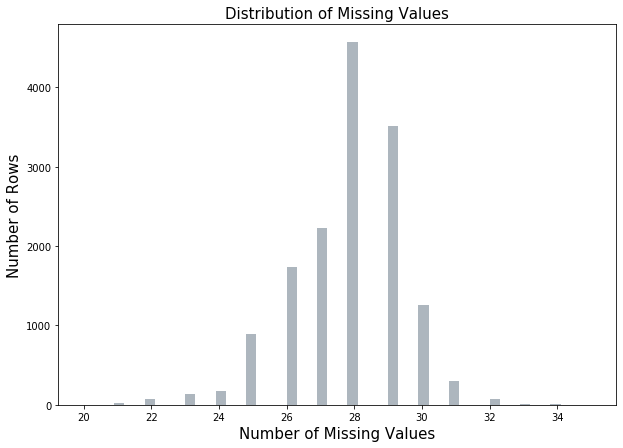

In [7]:
# Observe distribution of missing data across each row
# total number of columns (id excluded) is 57

# conclude: 
# no property is missing all data categories/ column
# on average, 28 data types were missing from each row
number_missing_per_row = df.isnull().sum(axis=1)
print(number_missing_per_row.describe())

plt.rcParams['figure.figsize'] = [10, 7]
number_missing_per_row = df.isnull().sum(axis=1)
sns.distplot(number_missing_per_row, color="#34495e", kde=False);
plt.title('Distribution of Missing Values', fontsize=15)
plt.xlabel('Number of Missing Values', fontsize=15)
plt.ylabel('Number of Rows', fontsize=15);

In [3]:
# Observe distribution of missing data across each data type/ column
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Column_Name', 'Number_Missing_Values']
missing_values['Percent_Missing'] = missing_values['Number_Missing_Values'] / len(df)
print(missing_values.Percent_Missing.describe())

count    59.000000
mean      0.471125
std       0.449764
min       0.000000
25%       0.000000
50%       0.362377
75%       0.966593
max       1.000000
Name: Percent_Missing, dtype: float64


In [4]:
# proportion of columns with less than 70% of missing data

missing_col = (missing_values.Percent_Missing < 0.70).sum() / len(missing_values)
missing_col

print("Percent of Columns not appropriate to be included as modeling variable {:.2f}"\
     .format(missing_col))

Percent of Columns not appropriate to be included as modeling variable 0.56


In [10]:
# The dataset contains good amount of columns being empty
# which might not be worthwhile to include for further analysis
# The following table contains columns with less than 70% of missing data
miss = missing_values[missing_values.Percent_Missing < 0.7]
miss

,Column_Name,Number_Missing_Values,Percent_Missing
0,id,0,0.000000
1,parcelid,0,0.000000
5,bathroomcnt,0,0.000000
6,bedroomcnt,0,0.000000
8,buildingqualitytypeid,5440,0.362377
9,calculatedbathnbr,22,0.001465
12,calculatedfinishedsquarefeet,0,0.000000
13,finishedsquarefeet12,43,0.002864
18,fips,0,0.000000
20,fullbathcnt,22,0.001465


In [5]:
# drop columns having too many empty data points, which is more than 70% empty
df = df.drop((missing_values.Column_Name[missing_values.Percent_Missing >= 0.7]), axis = 1).set_index("parcelid")
df = df.drop(columns = 'id')
df.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11289917,2.0,3.0,6.0,2.0,1458.0,1458.0,6037.0,2.0,NaN,NaN,...,97318.0,0.0,1.0,1970.0,108890.0,136104.0,2016.0,27214.0,2319.90,6.037901e+13
11705026,1.0,2.0,6.0,1.0,1421.0,1421.0,6037.0,1.0,NaN,NaN,...,96018.0,0.0,1.0,1911.0,11982.0,35606.0,2016.0,23624.0,543.69,6.037232e+13
14269464,3.0,4.0,NaN,3.0,2541.0,2541.0,6059.0,3.0,2.0,426.0,...,96958.0,0.0,NaN,2003.0,434887.0,880456.0,2016.0,445569.0,9819.72,6.059064e+13
11389003,2.0,3.0,6.0,2.0,1650.0,1650.0,6037.0,2.0,NaN,NaN,...,96037.0,0.0,1.0,1949.0,165000.0,614000.0,2016.0,449000.0,7673.19,6.037703e+13
11967869,1.0,2.0,5.0,1.0,693.0,693.0,6037.0,1.0,NaN,NaN,...,96023.0,0.0,1.0,1921.0,82416.0,274237.0,2016.0,191821.0,3267.47,6.037185e+13


OUTLIER DETECTED!!!


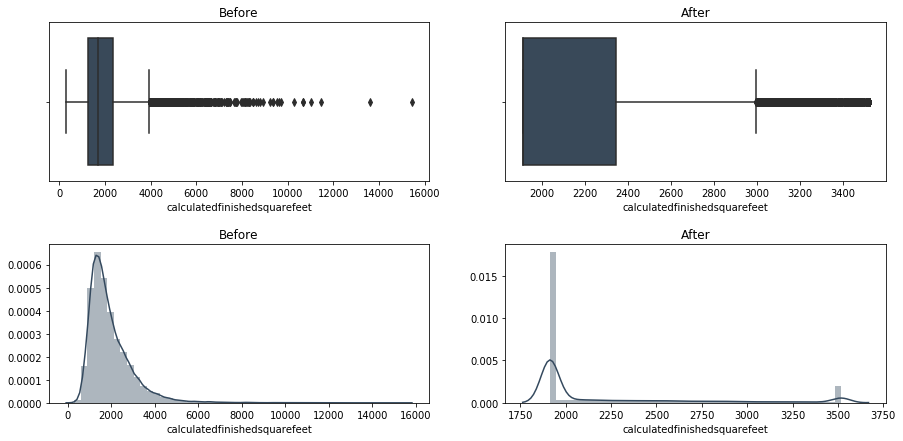

In [12]:
# Understanding data distribution
wrangle.find_outliers(df, 'calculatedfinishedsquarefeet')

OUTLIER DETECTED!!!


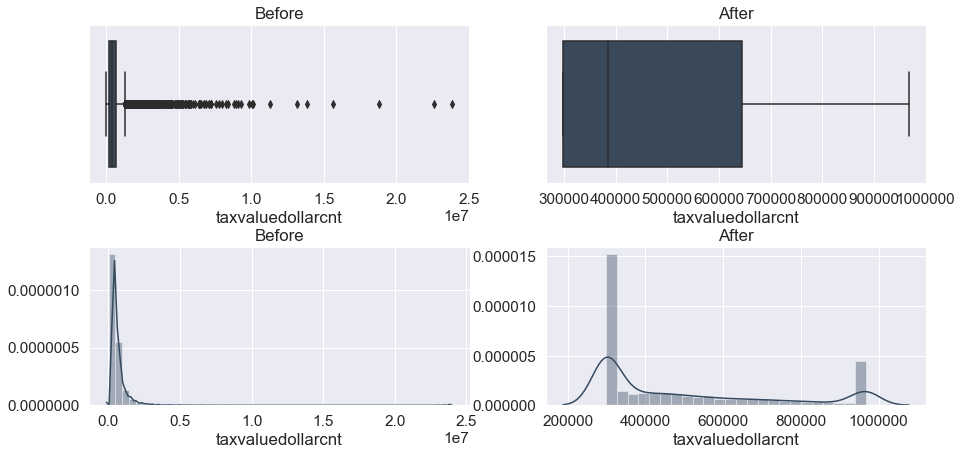

In [115]:
wrangle.find_outliers(df, 'taxvaluedollarcnt')

Disern Categorical vs Numerical Data
```python
numerical = df['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',\
             'garagecarcnt', 'garagetotalsqft','roomcnt', 'unitcnt',\
               'yearbuilt','lotsizesquarefeet']

categorical = ['buildingqualitytypeid', 'fips', 'heatingorsystemtypeid'\
              'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock',\
               'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip']

tax_related = ['fips','structuretaxvaluedollarcnt','taxvaluedollarcnt', 'assessmentyear',\
               'landtaxvaluedollarcnt','taxamount', 'censustractandblock']

geo = ['taxvaluedollarcnt','fips','latitude', 'longitude']```

In [6]:
geo = df[['taxvaluedollarcnt','fips','latitude', 'longitude']].reset_index()

In [92]:
tax_related = df[['fips','taxvaluedollarcnt','taxamount']]

In [93]:
tax_related.head()

,fips,taxvaluedollarcnt,taxamount
parcelid,,,
11289917,6037.0,136104.0,2319.90
11705026,6037.0,35606.0,543.69
14269464,6059.0,880456.0,9819.72
11389003,6037.0,614000.0,7673.19
11967869,6037.0,274237.0,3267.47


In [99]:
new_name = ["fips", "taxable", "tax"] 
tax_related.rename(columns=dict(zip(tax_related.columns, new_name)), inplace = True)
tax_related = tax_related.dropna()

In [101]:
tax_related["tax_rate"] = tax_related.tax/ tax_related.taxable

In [102]:
tax_related.fips.unique()

array([6037., 6059., 6111.])

In [103]:
LA = tax_related[tax_related.fips == 6037.0]
Orange_County = tax_related[tax_related.fips == 6059.0]
Ventura = tax_related[tax_related.fips == 6111.0]

In [105]:
LA.head()

,fips,taxable,tax,tax_rate
parcelid,,,,
11289917,6037.0,136104.0,2319.90,0.017045
11705026,6037.0,35606.0,543.69,0.015270
11389003,6037.0,614000.0,7673.19,0.012497
11967869,6037.0,274237.0,3267.47,0.011915
11696784,6037.0,168828.0,2135.39,0.012648


In [106]:
print(Ventura.tax_rate.describe())
print(Orange_County.tax_rate.describe())
print(LA.tax_rate.describe())

count    1295.000000
mean        0.012052
std         0.008276
min         0.000787
25%         0.010741
50%         0.011249
75%         0.011925
max         0.294865
Name: tax_rate, dtype: float64
count    4096.000000
mean        0.012120
std         0.003220
min         0.001712
25%         0.010616
50%         0.011524
75%         0.012529
max         0.107350
Name: tax_rate, dtype: float64
count    9620.000000
mean        0.014175
std         0.007663
min         0.001071
25%         0.012122
50%         0.012636
75%         0.014410
max         0.452884
Name: tax_rate, dtype: float64


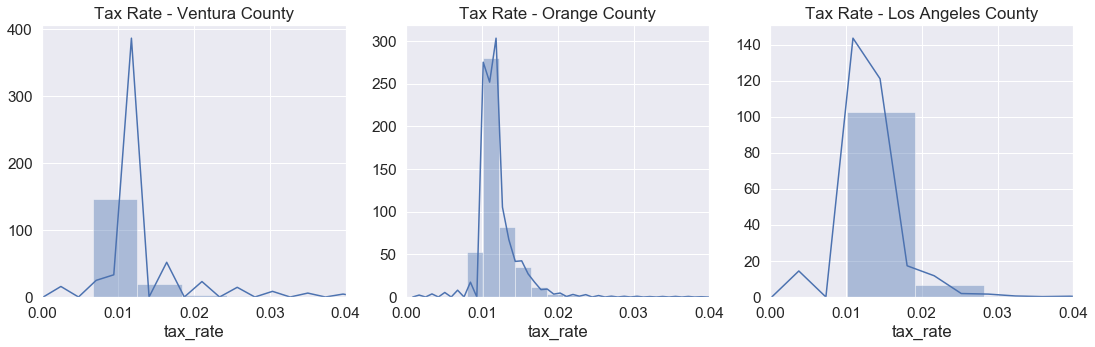

In [107]:
from matplotlib import gridspec
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1, 4)
sns.set(font_scale=1.4)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

# 06111        Ventura County
# 06059        Orange County
# 06037        Los Angeles County

ax1.set_title("Tax Rate - Ventura County")
ax2.set_title("Tax Rate - Orange County")
ax3.set_title("Tax Rate - Los Angeles County")

ax1.set_xlim([0, 0.04])
ax2.set_xlim([0, 0.04])
ax3.set_xlim([0, 0.04])

sns.distplot(Ventura.tax_rate, bins = 50, ax = ax1)
sns.distplot(Orange_County.tax_rate, bins = 50, ax = ax2)
sns.distplot(LA.tax_rate, bins = 50, ax = ax3)

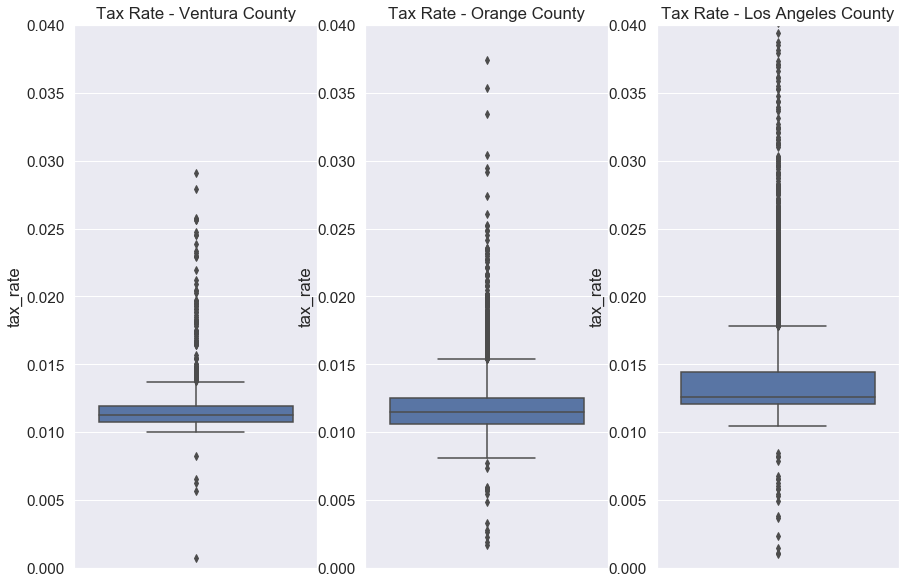

In [111]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 4)
sns.set(font_scale=1.4)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

# 06111        Ventura County
# 06059        Orange County
# 06037        Los Angeles County

ax1.set_title("Tax Rate - Ventura County")
ax2.set_title("Tax Rate - Orange County")
ax3.set_title("Tax Rate - Los Angeles County")

ax1.set_ylim([0, 0.04])
ax2.set_ylim([0, 0.04])
ax3.set_ylim([0, 0.04])

sns.boxplot(y = Ventura.tax_rate, ax = ax1)
sns.boxplot(y = Orange_County.tax_rate, ax = ax2)
sns.boxplot(y = LA.tax_rate, ax = ax3)

In [8]:
categorical = df[['taxvaluedollarcnt','buildingqualitytypeid', 'heatingorsystemtypeid',\
              'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock',\
               'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip']]

In [9]:
numerical = df[['taxvaluedollarcnt','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',\
             'garagecarcnt', 'garagetotalsqft','roomcnt', 'unitcnt', 'yearbuilt','lotsizesquarefeet']]
numerical.head()

,taxvaluedollarcnt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,roomcnt,unitcnt,yearbuilt,lotsizesquarefeet
parcelid,,,,,,,,,,
11289917,136104.0,2.0,3.0,1458.0,NaN,NaN,0.0,1.0,1970.0,8284.0
11705026,35606.0,1.0,2.0,1421.0,NaN,NaN,0.0,1.0,1911.0,6707.0
14269464,880456.0,3.0,4.0,2541.0,2.0,426.0,0.0,NaN,2003.0,4975.0
11389003,614000.0,2.0,3.0,1650.0,NaN,NaN,0.0,1.0,1949.0,7300.0
11967869,274237.0,1.0,2.0,693.0,NaN,NaN,0.0,1.0,1921.0,2908.0


**Handle na in numerical data columns**
> fill in with median instead of drop na

some numerical data type contain plenty of na,
if drop all rows containing na, will loose a lot of data

Process these column: 'garagecarcnt','garagetotalsqft','unitcnt','yearbuilt','lotsizesquarefeet'

In [10]:
values = {"garagecarcnt": numerical.garagecarcnt.median(),\
          "unitcnt": numerical.unitcnt.median(),\
          "garagetotalsqft":numerical.garagetotalsqft.median(),\
          "lotsizesquarefeet":numerical.lotsizesquarefeet.median(),\
             "yearbuilt":numerical.yearbuilt.median()}
numerical = numerical.fillna(value=values)

numerical.head()

,taxvaluedollarcnt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,roomcnt,unitcnt,yearbuilt,lotsizesquarefeet
parcelid,,,,,,,,,,
11289917,136104.0,2.0,3.0,1458.0,2.0,462.0,0.0,1.0,1970.0,8284.0
11705026,35606.0,1.0,2.0,1421.0,2.0,462.0,0.0,1.0,1911.0,6707.0
14269464,880456.0,3.0,4.0,2541.0,2.0,426.0,0.0,1.0,2003.0,4975.0
11389003,614000.0,2.0,3.0,1650.0,2.0,462.0,0.0,1.0,1949.0,7300.0
11967869,274237.0,1.0,2.0,693.0,2.0,462.0,0.0,1.0,1921.0,2908.0


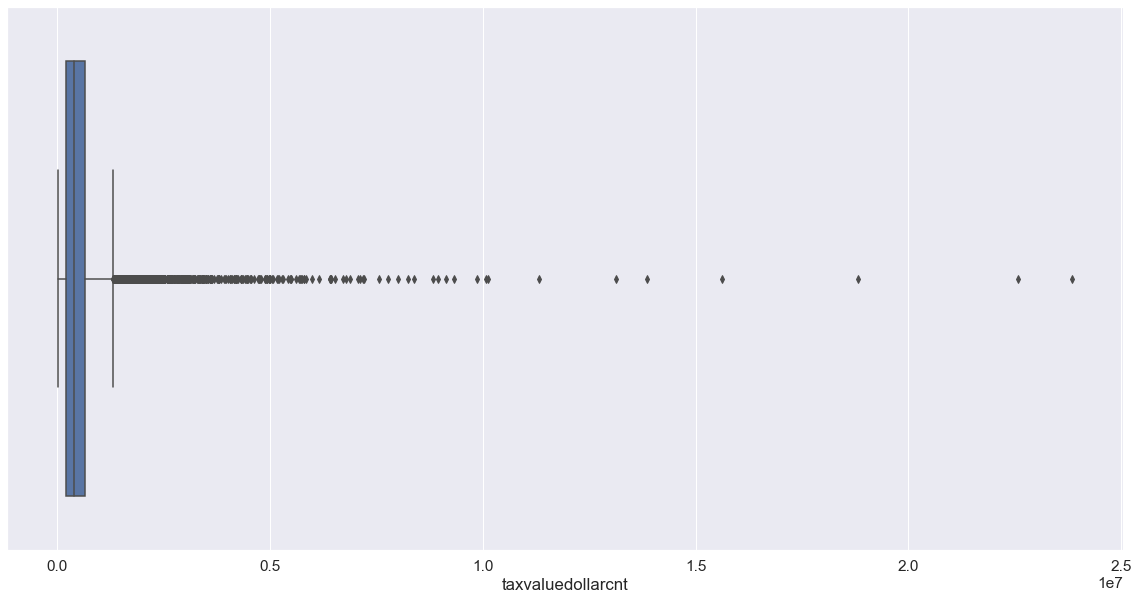

In [114]:
fig = plt.figure(figsize=(20,10))
sns.boxplot(x = numerical.taxvaluedollarcnt)

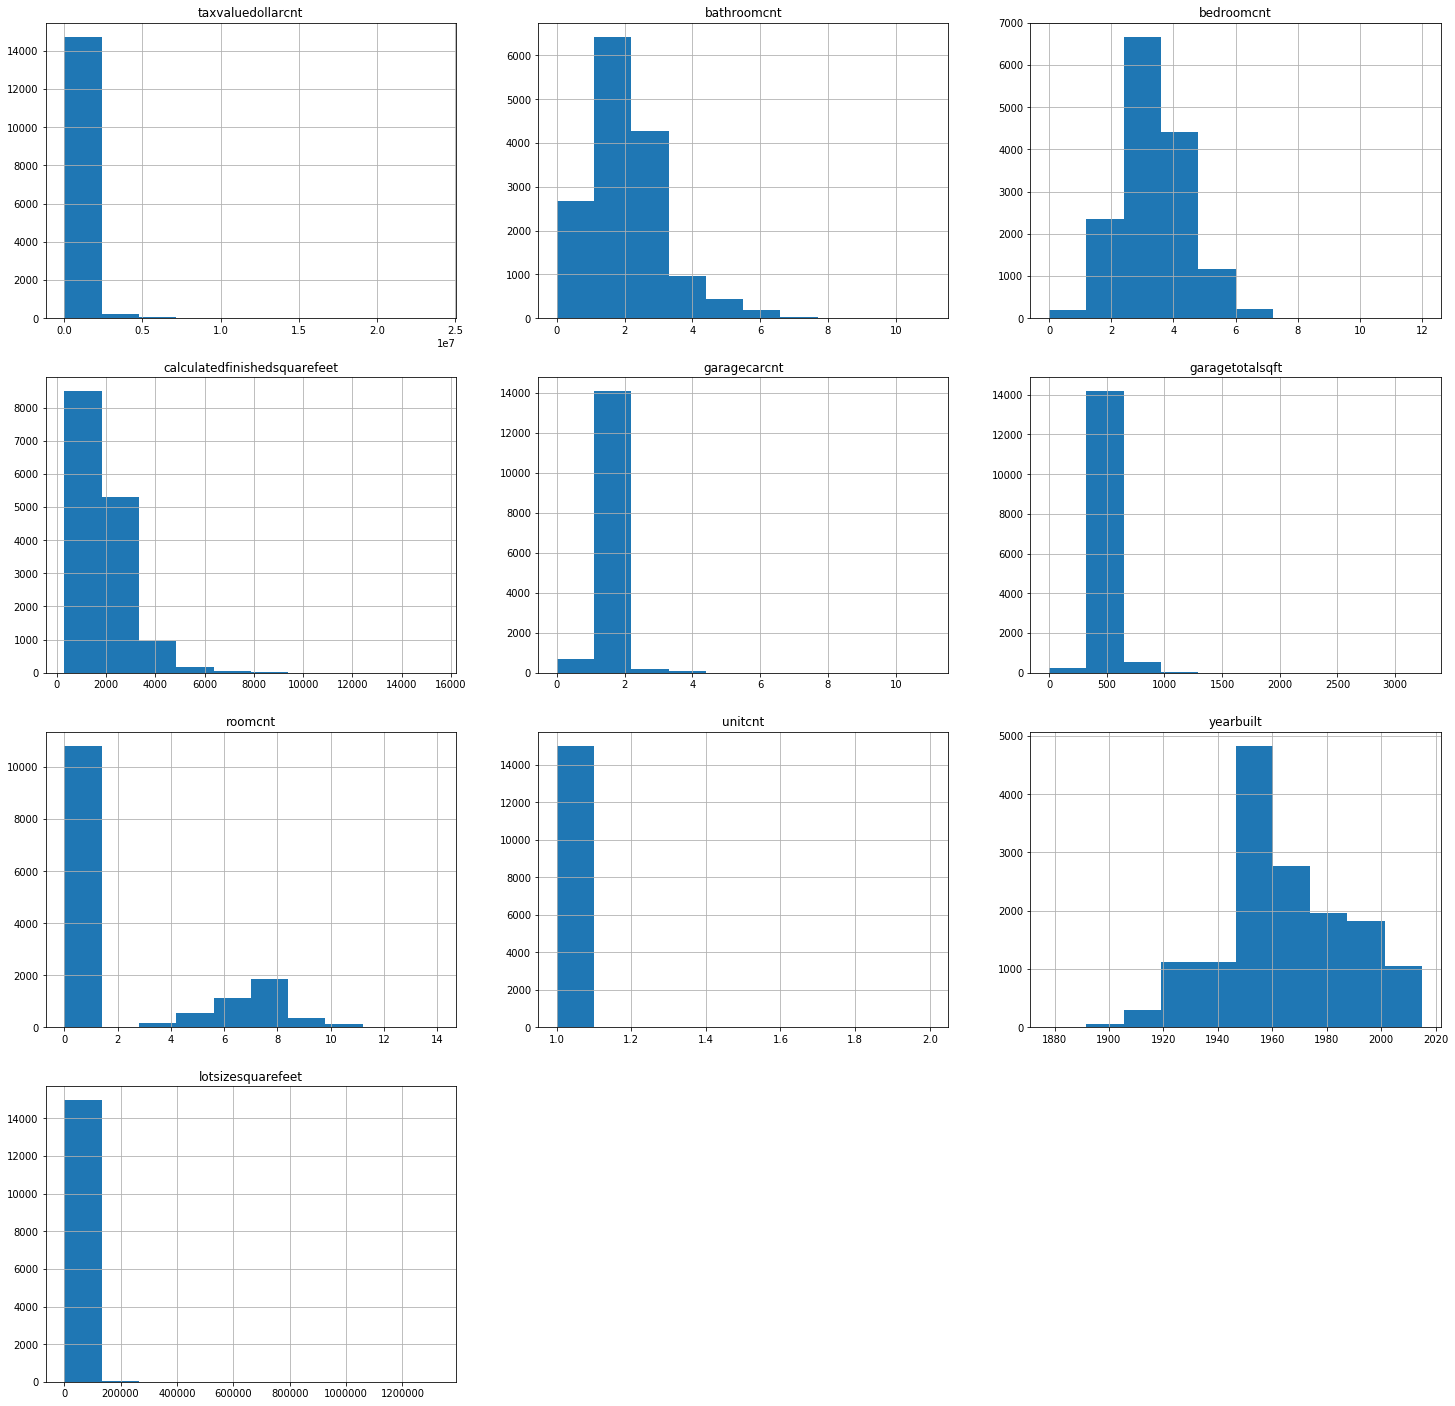

In [11]:
plt.figure(figsize=(25, 25))

for i, col in enumerate(['taxvaluedollarcnt', 'bathroomcnt', 'bedroomcnt',\
       'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft',\
       'roomcnt', 'unitcnt', 'yearbuilt', 'lotsizesquarefeet']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = numerical[col]  
    plt.subplot(4, 3, plot_number)
    plt.title(col)
    series.hist(density=False, cumulative=False, log=False)

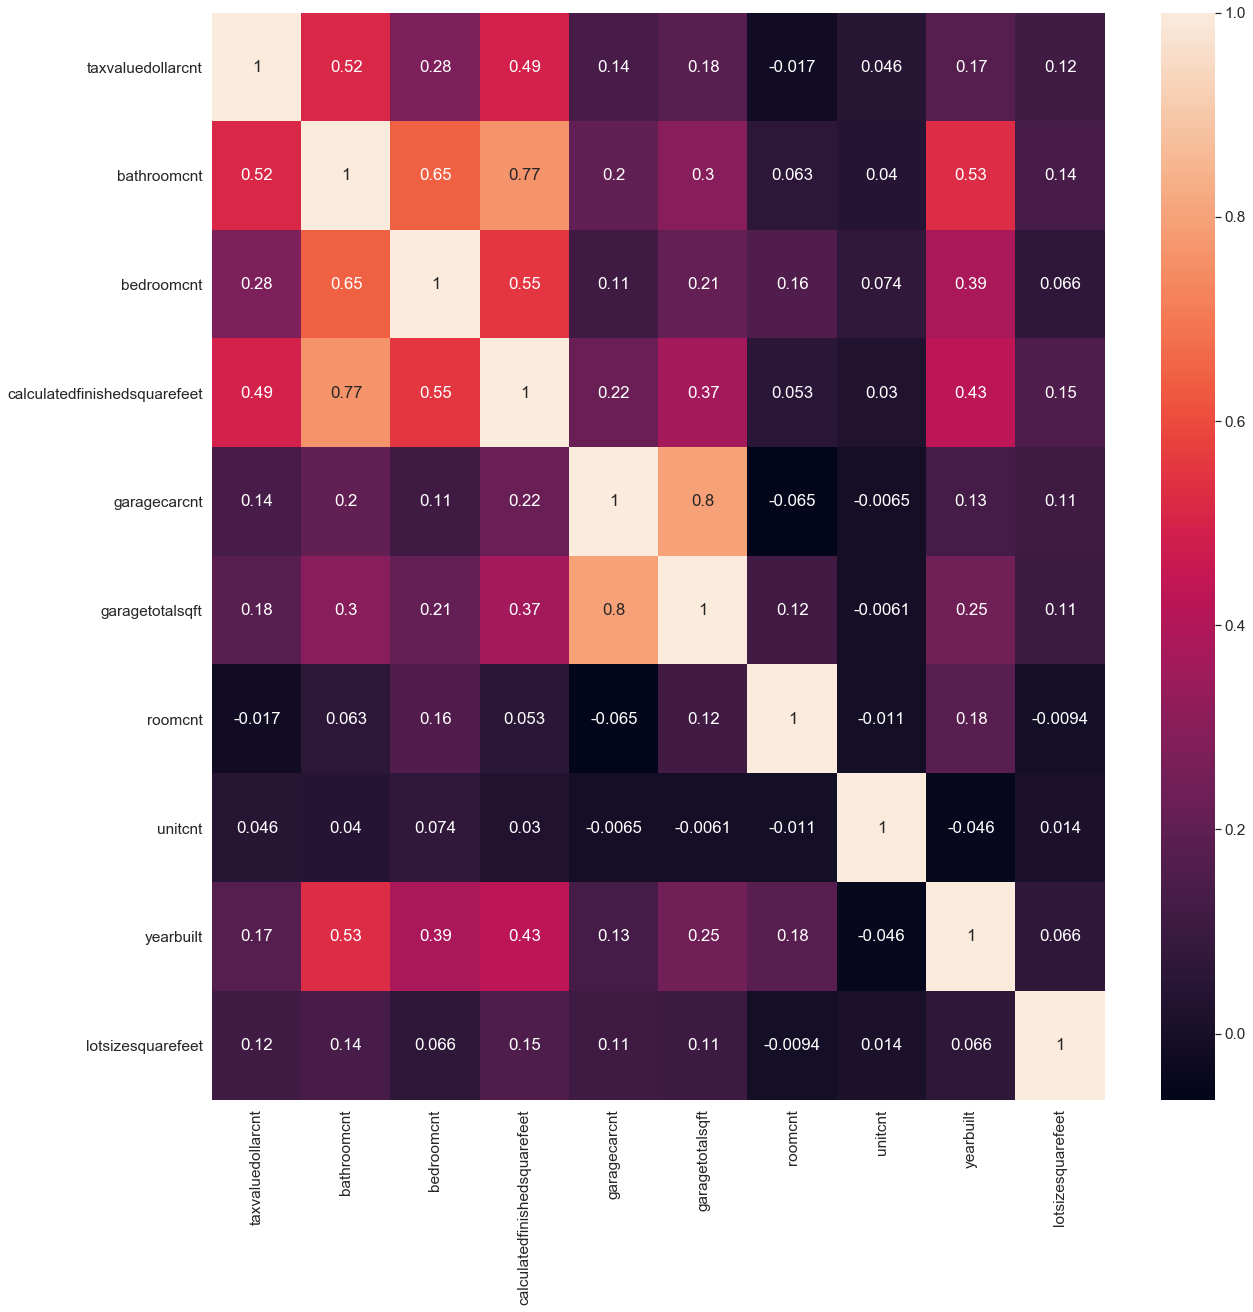

In [19]:
# Visualize relationship in Pearson R among all numerical features
plt.figure(figsize=(20,20))
sns.set(font_scale=1.4)
Numerical_Heatmap = sns.heatmap(numerical.corr(),annot=True)
fig = Numerical_Heatmap.get_figure()
fig.savefig("Numerical_Heatmap.png") 

DATA ACQUISITION >> DATA TIDY >> **(EXPLORE <=> TRANSFORM) >> MODEL** >> DELIVER

In [15]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import split_scale

In [19]:
# split train and test data with numerical dataframe for model building
train, test = split_scale.split_my_data(numerical, train_ratio=.80, seed=123)

# **Initial Model - constructed with number of bedroom, bathroom and squarefeet to predict property value** 

In [17]:
base_train_X = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
base_train_y = train.taxvaluedollarcnt

## Initial Model - the summary of baseline model without data scaling

In [18]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
## fit a OLS model 
X = sm.add_constant(base_train_X)
est = sm.OLS(base_train_y, X).fit()
est.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     2525.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:02:05   Log-Likelihood:            -1.7625e+05
No. Observations:               12009   AIC:                         3.525e+05
Df Residuals:                   12005   BIC:                         3.525e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -2.842e+04   1.92e+04     -1.478      0.139   -6.61e+04    9274.319
bathroomcnt                   6.519e+04   1.01e+04      6.439      0.000    4.53e+04     8.5e+04
bedroomcnt                   -1.488e+05   7371.945    -20.180      0.000   -1.63e+05   -1.34e+05
calculatedfinishedsquarefeet   468.3379     10.233     45.769      0.000     448.280     488.396
==============================================================================
Omnibus:                    19082.375   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27878473.350
Skew:                           9.927   Prob(JB):                         0.00
Kurtosis:                     238.204   Cond. No.                     8.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Initial Model - with more data preprocessing

In [20]:
scaler, base_train_scaled = split_scale.standard_scaler(train)

In [21]:
base_train_scaled_X = base_train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
base_train_scaled_y = base_train_scaled.taxvaluedollarcnt

In [22]:
X = sm.add_constant(base_train_scaled_X)
est = sm.OLS(base_train_scaled_y, X).fit()
est.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     2525.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:03:17   Log-Likelihood:                -14103.
No. Observations:               12009   AIC:                         2.821e+04
Df Residuals:                   12005   BIC:                         2.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         9.541e-18      0.007   1.34e-15      1.000      -0.014       0.014
bathroomcnt                      0.0922      0.014      6.439      0.000       0.064       0.120
bedroomcnt                      -0.1934      0.010    -20.180      0.000      -0.212      -0.175
calculatedfinishedsquarefeet     0.6493      0.014     45.769      0.000       0.621       0.677
==============================================================================
Omnibus:                    19082.375   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27878473.350
Skew:                           9.927   Prob(JB):                         0.00
Kurtosis:                     238.204   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
import model

MSE:  0.6131594110582133 SSE:  7363.431367398083 RMSE:  0.7830449610706994 r^2:  0.3868405889417865


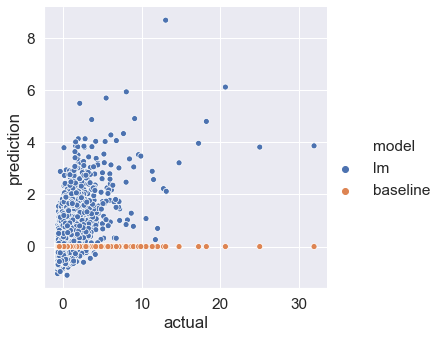

In [118]:
rf = pd.DataFrame(base_train_scaled_y)
rf = model.linear_model(base_train_scaled_X, base_train_scaled_y)
baseline = model.compute_baseline(base_train_scaled_y)
model.evaluate(rf.taxvaluedollarcnt, rf.lm)
model.plot_linear_model(rf.taxvaluedollarcnt, rf.lm, baseline)

In [29]:
import features
coef_base = features.lasso_cv_coef(base_train_scaled_X, base_train_scaled_y)
coef_base

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


bathroomcnt                     0.403557
calculatedfinishedsquarefeet    0.260088
bedroomcnt                     -0.124806
dtype: float64

In [30]:
X = sm.add_constant(base_train_scaled_X[['bathroomcnt','calculatedfinishedsquarefeet']])
est = sm.OLS(base_train_scaled_y, X).fit()
est.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     2548.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:55:57   Log-Likelihood:                -14915.
No. Observations:               12009   AIC:                         2.984e+04
Df Residuals:                   12006   BIC:                         2.986e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         9.541e-18      0.008   1.25e-15      1.000      -0.015       0.015
bathroomcnt                      0.3373      0.012     28.193      0.000       0.314       0.361
calculatedfinishedsquarefeet     0.2421      0.012     20.233      0.000       0.219       0.266
==============================================================================
Omnibus:                    19827.882   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32672261.891
Skew:                          10.747   Prob(JB):                         0.00
Kurtosis:                     257.624   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Takeaway from building initial model**
1. The prediction isn't ideal when using raw data or scaled data. (Refer to the summary tables presented above) 
2. Feature selection indicated number of bathroom and calculated sq ft might be more impactful.  But when only use these two for modeling, the performance of model was worse.

# Second Model - Include All Numerical Numbers

In [25]:
import split_scale
# only scale train for actual modeling
scaler, train_scaled = split_scale.standard_scaler(train)
# also scale test so we can perform elimination feature engineering
scaler, fe_train_scaled, fe_test_scaled =  split_scale.standard_scaler_all(train, test)

In [26]:
X_train = train_scaled.drop(columns = "taxvaluedollarcnt")
y_train = train_scaled.taxvaluedollarcnt

X_train_feature = fe_train_scaled.drop(columns = "taxvaluedollarcnt")
y_train_feature = fe_train_scaled.taxvaluedollarcnt

X_test_feature = fe_test_scaled.drop(columns = "taxvaluedollarcnt")
y_test_feature = fe_test_scaled.taxvaluedollarcnt

In [33]:
# perform linear regression with all numerical data
# without feature engineering

X = sm.add_constant(X_train)
est = sm.OLS(y_train, X).fit()
est.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     897.6
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:13:49   Log-Likelihood:                -13949.
No. Observations:               12009   AIC:                         2.792e+04
Df Residuals:                   11999   BIC:                         2.799e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         9.541e-18      0.007   1.35e-15      1.000      -0.014       0.014
bathroomcnt                      0.1441      0.015      9.752      0.000       0.115       0.173
bedroomcnt                      -0.1838      0.010    -19.104      0.000      -0.203      -0.165
calculatedfinishedsquarefeet     0.6743      0.015     45.948      0.000       0.646       0.703
garagecarcnt                    -0.0007      0.012     -0.056      0.956      -0.025       0.024
garagetotalsqft                 -0.0501      0.013     -3.838      0.000      -0.076      -0.025
roomcnt                         -0.0221      0.008     -2.944      0.003      -0.037      -0.007
unitcnt                          0.0086      0.007      1.204      0.229      -0.005       0.023
yearbuilt                       -0.1207      0.008    -14.224      0.000      -0.137      -0.104
lotsizesquarefeet            -2.134e-05      0.007     -0.003      0.998      -0.014       0.014
==============================================================================
Omnibus:                    18729.394   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25871802.802
Skew:                           9.555   Prob(JB):                         0.00
Kurtosis:                     229.583   Cond. No.                         4.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
import features

In [34]:
coef_base = features.lasso_cv_coef(X_train, y_train)
coef_base

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


calculatedfinishedsquarefeet    0.662651
bathroomcnt                     0.131928
unitcnt                         0.003829
lotsizesquarefeet               0.000000
garagecarcnt                   -0.000000
roomcnt                        -0.020028
garagetotalsqft                -0.042839
yearbuilt                      -0.112360
bedroomcnt                     -0.167963
dtype: float64

In [30]:
number_of_features = features.optimal_number_of_features(X_train_feature, y_train_feature, X_test_feature, y_test_feature)
selected_features_rfe = features.optimal_features(X_train_feature, y_train_feature, number_of_features)

In [31]:
selected_features_rfe

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'garagetotalsqft', 'yearbuilt'],
      dtype='object')

In [36]:
inv_scaler, inv_trian = split_scale.my_inv_transform(scaler, train_scaled)

inv_X_train = inv_trian.drop(columns = "taxvaluedollarcnt")
inv_y_train = inv_trian.taxvaluedollarcnt

In [46]:
X_train = train_scaled.drop(columns = "taxvaluedollarcnt")
y_train = train_scaled.taxvaluedollarcnt

X_train_feature = fe_train_scaled.drop(columns = "taxvaluedollarcnt")
y_train_feature = fe_train_scaled.taxvaluedollarcnt

X_test_feature = fe_test_scaled.drop(columns = "taxvaluedollarcnt")
y_test_feature = fe_test_scaled.taxvaluedollarcnt

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def create_polynomial_regression_model(degree):
	result = pd.DataFrame(y_train)
	result['actual'] = pd.DataFrame(y_train)
	#result['test_actual'] = pd.DataFrame(y_test)
	result['baseline'] = np.array([y_train.mean()]*len(y_train))
    
	"Creates a polynomial regression model for the given degree"
	poly_features = PolynomialFeatures(degree=degree)
  	# transforms the existing features to higher degree features.
	X_train_poly = poly_features.fit_transform(X_train_feature)
  	# fit the transformed features to Linear Regression
	poly_model = LinearRegression()
	poly_model.fit(X_train_poly, y_train_feature)

  	# predicting on training data-set
	y_train_predicted = poly_model.predict(X_train_poly)
	result['y_train_pred']=y_train_predicted
    
	# predicting on test data-set
	y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_feature))
	result['y_test_pred']=y_train_predicted
    
	# evaluating the model on training dataset
	rmse_train = np.sqrt(mean_squared_error(y_train_feature, y_train_predicted))
	r2_train = r2_score(y_train_feature, y_train_predicted)
  
	# evaluating the model on test dataset
	rmse_test = np.sqrt(mean_squared_error(y_test_feature, y_test_predict))
	r2_test = r2_score(y_test_feature, y_test_predict)
	
	print("The model performance for the training set")
	print("-------------------------------------------")
	print("RMSE of training set is {}".format(rmse_train))
	print("R2 score of training set is {}".format(r2_train))
  
	print("\n")
  
	print("The model performance for the test set")
	print("-------------------------------------------")
	print("RMSE of test set is {}".format(rmse_test))
	print("R2 score of test set is {}".format(r2_test))

	#return y_train_predicted, y_test_predict

#sns.scatterplot(X_test.flatten(), y_test_predict.flatten(), color='r')

In [61]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.7030250210499092
R2 score of training set is 0.5057558197777745


The model performance for the test set
-------------------------------------------
RMSE of test set is 0.748822785700032
R2 score of test set is 0.43610425694303967


In [62]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.7334962344565102
R2 score of training set is 0.4619832740381201


The model performance for the test set
-------------------------------------------
RMSE of test set is 0.7543592171885171
R2 score of test set is 0.4277350903728523


In [64]:
# Create correlation matrix
corr_matrix = numerical.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
get = [column for column in upper.columns if any(upper[column] > 0.5)]
get

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'garagetotalsqft',
 'yearbuilt']

In [72]:
X_train_ff = fe_train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet','garagetotalsqft', 'yearbuilt']]
y_train_ff = fe_train_scaled.taxvaluedollarcnt

X_test_ff = fe_test_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet','garagetotalsqft', 'yearbuilt']]
y_test_ff = fe_test_scaled.taxvaluedollarcnt
                           

In [79]:
def create_polynomial_regression_model(degree):
	result2 = pd.DataFrame(y_train)
	result2['actual'] = pd.DataFrame(y_train_ff)
	#result['test_actual'] = pd.DataFrame(y_test)
	result2['baseline'] = np.array([y_train_ff.mean()]*len(y_train_ff))
    
	"Creates a polynomial regression model for the given degree"
	poly_features = PolynomialFeatures(degree=degree)
  	# transforms the existing features to higher degree features.
	X_train_poly = poly_features.fit_transform(X_train_ff)
  	# fit the transformed features to Linear Regression
	poly_model = LinearRegression()
	poly_model.fit(X_train_poly, y_train_ff)

  	# predicting on training data-set
	y_train_predicted = poly_model.predict(X_train_poly)
	result2['y_train_pred']=y_train_predicted
    
	# predicting on test data-set
	y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_ff))
	result2['y_test_pred']=y_train_predicted
    
	# evaluating the model on training dataset
	rmse_train = np.sqrt(mean_squared_error(y_train_ff, y_train_predicted))
	r2_train = r2_score(y_train_feature, y_train_predicted)
  
	# evaluating the model on test dataset
	rmse_test = np.sqrt(mean_squared_error(y_test_ff, y_test_predict))
	r2_test = r2_score(y_test_feature, y_test_predict)
	
	print("The model performance for the training set")
	print("-------------------------------------------")
	print("RMSE of training set is {}".format(rmse_train))
	print("R2 score of training set is {}".format(r2_train))
  
	print("\n")
  
	print("The model performance for the test set")
	print("-------------------------------------------")
	print("RMSE of test set is {}".format(rmse_test))
	print("R2 score of test set is {}".format(r2_test))
	return result2

	#return y_train_predicted, y_test_predict

#sns.scatterplot(X_test.flatten(), y_test_predict.flatten(), color='r')

In [81]:
result2 = create_polynomial_regression_model(3) # try less features

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.7219296080962163
R2 score of training set is 0.47881764095404333


The model performance for the test set
-------------------------------------------
RMSE of test set is 0.7297213149957081
R2 score of test set is 0.4645057913520285


In [ ]:
# Polynomial Regression-nth order
plt.scatter(new_X_test, y_test, s=10, alpha=0.3)

for degree in [1,2,3,4,5,6,7]:

    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(new_X_train,y_train)

    y_plot = model.predict(new_X_test)

    plt.plot(new_X_test, y_plot, label="degree %d" % degree

             +'; $R^2$: %.2f' % model.score(x_test_set, y_test_set))

plt.legend(loc='upper right')

plt.xlabel("Test LSTAT Data")

plt.ylabel("Predicted Price")

plt.title("Variance Explained with Varying Polynomial")

plt.show()